In [1]:
import matplotlib.pyplot as plt
import numpy as np

from src.CipherBreaker import CipherBreaker
from src.CipherUtils import (
    TextDecoder,
    TextEncoder,
    CipherGenerator,
    TextPreProcessor,
)
from src.ProbabilityMatrix import ProbabilityMatrix

from difflib import SequenceMatcher

In [2]:
def similar(a, b):
    """
    Given two strings a, b it returns a percentage of matching characters among the two
    """

    return SequenceMatcher(None, a.replace(" ", ""), b.replace(" ", "")).ratio()

In [3]:
# Initialize classes and obtain the matrix of probabilities by training on the provided text
cipher_generator = CipherGenerator()
preprocess = TextPreProcessor()
text_encoder = TextEncoder()
text_decoder = TextDecoder()


# List of text file paths to build our corpus (where we learn the transitions probs)
file_paths = [
    "texts/moby_dick.txt",
    "texts/shakespeare.txt",
    "texts/james-joyce-a-portrait-of-the-artist-as-a-young-man.txt",
    "texts/james-joyce-dubliners.txt",
    "texts/james-joyce-ulysses.txt",
]

texts = []
for file_path in file_paths:
    with open(file_path, "r") as file:
        texts.append(file.read())

corpus = "".join(texts)


# preprocess the text, removing extra-characters

corpus = preprocess.lower(corpus)
unknown_chars = preprocess.unknown_chars(corpus)
# print(unknown_chars)
corpus = preprocess.remove_unknown_chars(corpus, unknown_chars=unknown_chars)
corpus = preprocess.remove_additional_spaces(corpus)

preprocess.save_text(
    corpus
)  # save text after preprocessing inside text_preprocessed.txt


# compute the transition probs
probability_matrix = ProbabilityMatrix(corpus)
probability_matrix.compute_probability_table()

In [4]:
def prepare_subtexts(path_to_file, lengths):
    """
    This function returns the subtext to use to assess accuracy in decryption

    Input:
        - path_to_file (str) giving the path to the text file
        - lengths (list of int) giving the text lengths to consider
    """

    with open(path_to_file, "r") as input_file:
        full_text = input_file.read()

    full_text = preprocess.lower(full_text)
    unknown_chars = preprocess.unknown_chars(full_text)
    full_text = preprocess.remove_unknown_chars(full_text, unknown_chars=unknown_chars)
    full_text = preprocess.remove_additional_spaces(full_text)

    subtexts = [
        " ".join(full_text.split()[: lengths[i]]) for i in range(len(lengths))
    ]  # Contains the ones for the varying lengths

    return subtexts

In [19]:
def accuracy_varying_text_length(
    subtexts,
    cipher_generator,
    probability_matrix,
    extract_top=5,
    n_iterations=3,
    max_iterations=10000,
    nstart=3,
):
    """
    This function assesses the accuracy of the MCMC decryption.
    Input:
        - subtexts (list of str): a vector of text of different length
        - cipher_generator (CipherGenerator instance)
        - probability_matrix
        - extract_top(int) : After cipher breaking how many of the top ones we want to retain
        - n_iterations (int) : number of times we want to repeat the encryption-decryption for each text
        - max_iterations (int) : number of iterations in the cipher breaking procedure
        - nstart (int) : number of starting points in the cipher breaking procedure

    For each subtext it encrypts it and decrypts it n_iteration times.
        Everytime it finishes decrypting it compares the best extract_top (in terms of log likelihood) with the original string,
        and computes the accuracy as the proportion of characters matching for the string which matches best.
        Then for each subtext these are averaged over all n_iterations runs and are stored.
    """
    mean_accuracy = []

    for subtext in subtexts:
        total_iterations = 0
        for _ in range(n_iterations):
            cipher = cipher_generator.generate_cipher()
            encoded_text = text_encoder.encode_text(subtext, cipher)

            # Initialize a code breaker for that encoded message
            cipher_breaker_nstart = CipherBreaker(
                cipher_generator=cipher_generator,
                ciphered_text=encoded_text,
                probability_table=probability_matrix.probability_table,
            )

            # Break the code and store the extract_top in a dictionary (avoid printing)
            cipher_breaker_nstart.break_cipher_nstart(
                iterations=max_iterations, print_interval=max_iterations, nstart=nstart
            )
            best_dict = cipher_breaker_nstart.extract_best(
                n_extract=extract_top, return_likelihood=True
            )

            # Extract only the text and store it in a list
            best_dict_text = [t[0] for t in best_dict]
            print(best_dict_text)

            # Now we check the percentage of correct ones in the string we matched the most with
            total_iterations = total_iterations + max(
                [
                    similar(subtext, best_dict_text[l])
                    for l in range(len(best_dict_text))
                ]
            )

        mean_accuracy.append(total_iterations / n_iterations)

    return mean_accuracy

In [ ]:
lengths = [2 ** (i) for i in range(3, 6)]
# An example which runs very fast
subtexts = prepare_subtexts("texts/moby_dick.txt", lengths=lengths)
accuracy_varying_text_length(subtexts, cipher_generator, probability_matrix)

In [26]:
lengths = [10, 25, 50, 100, 250, 500, 1000]

In [27]:
# Use it on the Moby Dick text
subtexts = prepare_subtexts("texts/moby_dick.txt", lengths)
Moby_Dick_accuracy = accuracy_varying_text_length(
    subtexts, cipher_generator, probability_matrix
)


# Use it on the article text
subtexts = prepare_subtexts("texts/article_tipping.txt", lengths)
article_tipping_accuracy = accuracy_varying_text_length(
    subtexts, cipher_generator, probability_matrix
)

# Use it on the war message text
subtexts = prepare_subtexts("texts/eisenhower_speech.txt", lengths)
speech_accuracy = accuracy_varying_text_length(
    subtexts, cipher_generator, probability_matrix
)

Iter 0 of start 1: jmyzvhw neexdpto jynn xh domxyhn oexh fhywo yte phrhw xdpk
Iter 0 of start 2: arbdzeh woojptum abww je pmrjbew moje iebhm buo teceh jptv
Iter 0 of start 3: bgfnsay hccdwkpt bfhh da wtgdfah tcda qafyt fpc kalay dwkz
['cwalven stthimro cass he iowhaes othe beano art meden himq', 'cwalven stthimro cass he iowhaes othe beano art meden himx', 'cwalven stthidro cass he iowhaes othe beano art demen hidx', 'cwalyen stthidro cass he iowhaes othe meano art depen hidx', 'cwalyen stthipro cass he iowhaes othe meano art peden hipx']
Iter 0 of start 1: spiqydx zggljeav sizz ld jvplidz vgld wdixv iag edodx ljek
Iter 0 of start 2: ligdhfx juucqwkm lgjj cf qmicgfj mucf sfgxm gku wftfx cqwz
Iter 0 of start 3: eakxjhc uzznyqtv ekuu nh yvankhu vznh ghkcv ktz qhbhc nyqo
['muacwer lssthino mall te houtael oste dearo ans ieyer thif', 'muacwer dssthino madd te houtaed oste learo ans ieyer thif', 'muacler dssthino madd te houtaed oste wearo ans ieyer thif', 'muacwer dssthino madd te houtaed 

In [28]:
print("Moby Dick accuracy", Moby_Dick_accuracy)
print("Article accuracy", article_tipping_accuracy)
print("Eisenhower speech accuracy", speech_accuracy)

Moby Dick accuracy [0.4829931972789116, 0.6239316239316239, 0.7953795379537953, 0.697037037037037, 0.9981981981981982, 1.0, 1.0]
Article accuracy [0.3111111111111111, 0.6173913043478261, 0.42834138486312395, 0.6697038724373576, 0.9997108991037873, 1.0, 1.0]
Eisenhower speech accuracy [0.39716312056737585, 0.672463768115942, 0.64822695035461, 1.0, 0.9997103967564437, 0.9987063389391979, 0.9985742800114057]


In [29]:
# Write results to file
with open("outputs/MCMC_accuracies/Moby_Dick_accuracy.txt", "w") as file:
    # Convert each float to an integer and write it to the file
    for num in Moby_Dick_accuracy:
        file.write(str(num) + "\n")

with open("outputs/MCMC_accuracies/Article_accuracy.txt", "w") as file:
    # Convert each float to an integer and write it to the file
    for num in article_tipping_accuracy:
        file.write(str(num) + "\n")

with open("outputs/MCMC_accuracies/speech_accuracy.txt", "w") as file:
    # Convert each float to an integer and write it to the file
    for num in speech_accuracy:
        file.write(str(num) + "\n")

## plot


['10', '25', '50', '100', '250', '500', '1000']


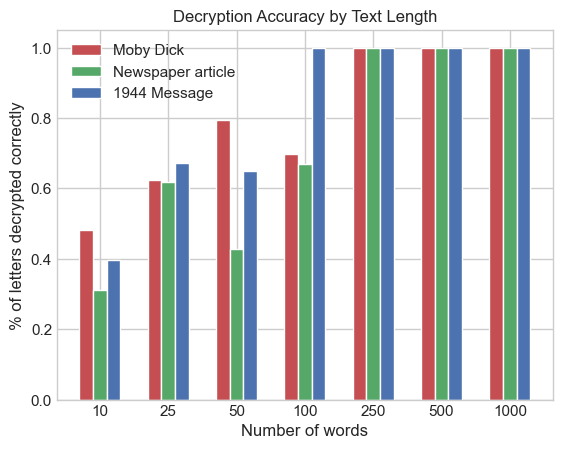

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Create a list of labels for the x-axis
labels = [str(length) for length in lengths]
print(labels)

# Set the width of each bar
bar_width = 0.2

# Set the positions of the bars on the x-axis
x_pos = np.arange(len(labels))

# Plot the results using a bar plot
plt.bar(x_pos - bar_width, Moby_Dick_accuracy, bar_width, color="r", label="Moby Dick")
plt.bar(
    x_pos, article_tipping_accuracy, bar_width, color="g", label="Newspaper article"
)
plt.bar(x_pos + bar_width, speech_accuracy, bar_width, color="b", label="1944 Message")

# Add labels, title, and legend
plt.xlabel("Number of words")
plt.ylabel("% of letters decrypted correctly")
plt.title("Decryption Accuracy by Text Length")
plt.xticks(x_pos, labels)
plt.legend()

# Display the plot
plt.show()

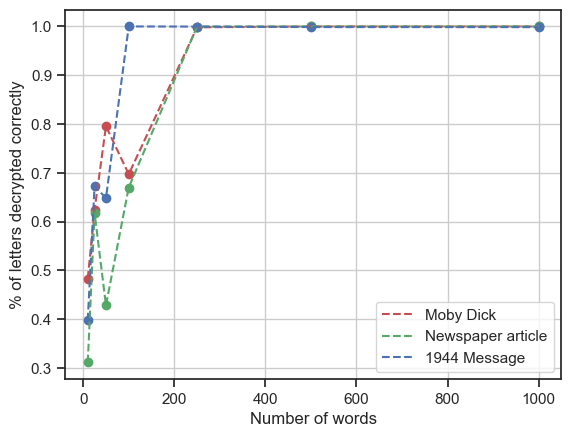

In [30]:
# Plotting the lines
plt.plot(lengths, Moby_Dick_accuracy, linestyle="--", color="r", label="Moby Dick")
plt.plot(
    lengths,
    article_tipping_accuracy,
    linestyle="--",
    color="g",
    label="Newspaper article",
)
plt.plot(lengths, speech_accuracy, linestyle="--", color="b", label="1944 Message")

plt.scatter(lengths, Moby_Dick_accuracy, color="r")
plt.scatter(lengths, article_tipping_accuracy, color="g")
plt.scatter(lengths, speech_accuracy, color="b")


# Adding labels and grid
plt.xlabel("Number of words")
plt.ylabel("% of letters decrypted correctly")
plt.grid(True)

# Adding legend
plt.legend()

# Display the plot
plt.show()

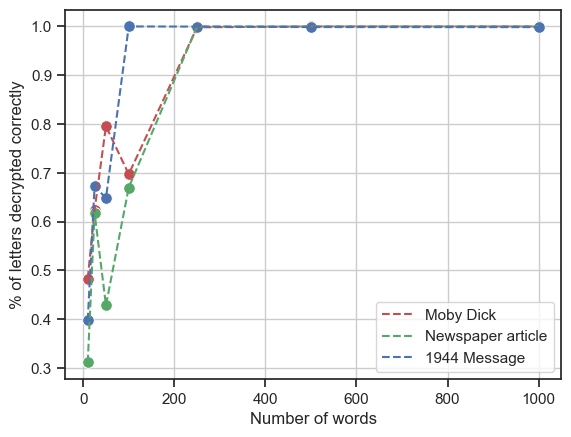

In [31]:
import seaborn as sns

# Create the plot using Seaborn
sns.set(style="ticks")

# Plotting the lines
sns.lineplot(
    x=lengths, y=Moby_Dick_accuracy, linestyle="--", color="r", label="Moby Dick"
)
sns.lineplot(
    x=lengths,
    y=article_tipping_accuracy,
    linestyle="--",
    color="g",
    label="Newspaper article",
)
sns.lineplot(
    x=lengths, y=speech_accuracy, linestyle="--", color="b", label="1944 Message"
)

# Adding scatter points
sns.scatterplot(x=lengths, y=Moby_Dick_accuracy, color="r", s=70)
sns.scatterplot(x=lengths, y=article_tipping_accuracy, color="g", s=70)
sns.scatterplot(x=lengths, y=speech_accuracy, color="b", s=70)

# Adding labels and grid
plt.xlabel("Number of words")
plt.ylabel("% of letters decrypted correctly")
plt.grid(True)

# Adding legend
plt.legend()

# Display the plot
plt.show()

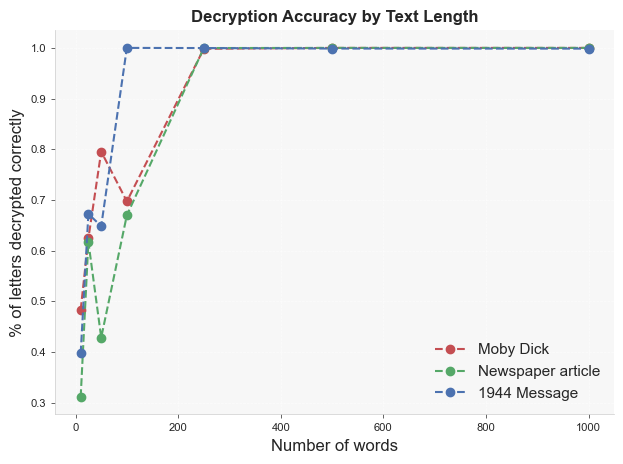

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting the lines
plt.plot(
    lengths,
    Moby_Dick_accuracy,
    linestyle="--",
    color="r",
    marker="o",
    label="Moby Dick",
)
plt.plot(
    lengths,
    article_tipping_accuracy,
    linestyle="--",
    color="g",
    marker="o",
    label="Newspaper article",
)
plt.plot(
    lengths,
    speech_accuracy,
    linestyle="--",
    color="b",
    marker="o",
    label="1944 Message",
)

# Set line width
plt.setp(plt.gca().spines.values(), linewidth=0.5)
plt.setp(plt.gca().xaxis.get_ticklines(), linewidth=0.5)
plt.setp(plt.gca().yaxis.get_ticklines(), linewidth=0.5)

# Customize marker size and edge color
marker_size = 5
marker_edge_color = "black"

plt.scatter(
    lengths, Moby_Dick_accuracy, color="r", edgecolor=marker_edge_color, s=marker_size
)
plt.scatter(
    lengths,
    article_tipping_accuracy,
    color="g",
    edgecolor=marker_edge_color,
    s=marker_size,
)
plt.scatter(
    lengths, speech_accuracy, color="b", edgecolor=marker_edge_color, s=marker_size
)

# Adding labels and grid
plt.xlabel("Number of words")
plt.ylabel("% of letters decrypted correctly")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Customize the grid color
plt.gca().set_facecolor("#F7F7F7")
plt.gca().grid(color="white")

# Adding legend
plt.legend()

# Adjust plot margins
plt.margins(0.05)

# Add a title
plt.title("Decryption Accuracy by Text Length", fontweight="bold")

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Show x-axis ticks on the top and y-axis ticks on the right
plt.gca().xaxis.tick_bottom()
plt.gca().yaxis.tick_left()

# Customize tick parameters
plt.tick_params(axis="both", direction="out", width=0.5, length=3, labelsize=8)

# Display the plot
plt.tight_layout()
plt.show()